In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier

In [3]:
train = pd.read_csv(r".\train.csv")
test = pd.read_csv(r".\test.csv")

In [4]:
PassengerId = test['PassengerId']

## 파생변수 생성

In [5]:
def convert_cabin(data, col):
    col_1 = []
    for i in data[col]:
        if str(i).split('/')[0] == 'nan':
            col_1.append(None)
        else:
            col_1.append(str(i).split('/')[0])

    col_2 = []
    col_3 = []
    for i in data[col]:
        if len(str(i).split('/')) == 3:
            col_2.append(str(i).split('/')[1])
            col_3.append(str(i).split('/')[2])
        elif len(str(i).split('/')) < 3:
            col_2.append(None)
            col_3.append(None)
    return col_1, col_2, col_3

In [6]:
train['Cabin1'] = convert_cabin(data=train, col = 'Cabin')[0]
train['Cabin2'] = convert_cabin(data=train, col = 'Cabin')[1]
train['Cabin3'] = convert_cabin(data=train, col = 'Cabin')[2]

In [7]:
test['Cabin1'] = convert_cabin(data=test, col = 'Cabin')[0]
test['Cabin2'] = convert_cabin(data=test, col = 'Cabin')[1]
test['Cabin3'] = convert_cabin(data=test, col = 'Cabin')[2]

## Null값 대체

In [8]:
# null 값(연속형변수) 대체하기 

train['Age'] = train['Age'].fillna(train['Age'].mean()) #평균값 대체
train['RoomService'] = train['RoomService'].fillna(train['RoomService'].median())
train['FoodCourt'] = train['FoodCourt'].fillna(train['FoodCourt'].median())
train['ShoppingMall'] = train['ShoppingMall'].fillna(train['FoodCourt'].median())
train['Spa'] = train['Spa'].fillna(train['Spa'].median())
train['VRDeck'] = train['VRDeck'].fillna(train['VRDeck'].median())

In [9]:
test['Age'] = test['Age'].fillna(test['Age'].mean()) #평균값 대체
test['RoomService'] = test['RoomService'].fillna(test['RoomService'].median())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].median())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['FoodCourt'].median())
test['Spa'] = test['Spa'].fillna(test['Spa'].median())
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].median())

In [10]:
# categorical value 대체하기 -> 최빈값 사용

train['HomePlanet'] = train['HomePlanet'].fillna(train['HomePlanet'].mode()[0])
train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mode()[0])
train['Destination'] = train['Destination'].fillna(train['Destination'].mode()[0])
train['VIP'] = train['VIP'].fillna(train['VIP'].mode()[0])
train['Cabin1'] = train['Cabin1'].fillna(train['Cabin1'].mode()[0])
train['Cabin2'] = train['Cabin2'].fillna(train['Cabin2'].mode()[0])
train['Cabin3'] = train['Cabin3'].fillna(train['Cabin3'].mode()[0])

In [11]:
test['HomePlanet'] = test['HomePlanet'].fillna(test['HomePlanet'].mode()[0])
test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mode()[0])
test['Destination'] = test['Destination'].fillna(test['Destination'].mode()[0])
test['VIP'] = test['VIP'].fillna(test['VIP'].mode()[0])
test['Cabin1'] = test['Cabin1'].fillna(test['Cabin1'].mode()[0])
test['Cabin2'] = test['Cabin2'].fillna(test['Cabin2'].mode()[0])
test['Cabin3'] = test['Cabin3'].fillna(test['Cabin3'].mode()[0])

In [53]:
# 사용할 컬럼 선택 및 변환

In [12]:
train_raw_columns = [i for i in train.columns]
test_raw_columns = [i for i in test.columns]

In [13]:
# passenger id, name, Cabin 제외

train_used_columns = [x for x in train_raw_columns if x not in ['PassengerId', 'Name', 'Cabin']]
test_used_columns = [x for x in test_raw_columns if x not in ['PassengerId', 'Name', 'Cabin']]

train = train[train_used_columns]
test = test[test_used_columns]

In [14]:
# cabin2 -> integer 변환

train['Cabin2'] = train['Cabin2'].astype('int')
test['Cabin2'] = test['Cabin2'].astype('int')

In [15]:
# categorical value(onehot/label)만 뽑는 함수

def categorical_feature(df):
    onehot_columns = []
    label_columns = []
    for i, x in zip(df.columns, df.dtypes):
        if x == object:
            onehot_columns.append(i)
        elif x == bool:
            label_columns.append(i)
        else :
            pass
    return onehot_columns, label_columns

In [16]:
train_categorical_columns = categorical_feature(train)
test_categorical_columns = categorical_feature(test)

In [17]:
train_onehot_target = train_categorical_columns[0]
train_label_target = train_categorical_columns[1]

test_onehot_target = test_categorical_columns[0]
test_label_target = test_categorical_columns[1]

In [18]:
# onehot타겟에서 cabin1 제외, label에 추가

train_onehot_target.remove('Cabin1')
test_onehot_target.remove('Cabin1')

train_label_target.append('Cabin1')
test_label_target.append('Cabin1')

In [19]:
# categorical feature에 대해 label-encoding 수행하는 함수

def label_encoder(data, target_cols):
    for i in range(len(target_cols)):
        encoder = LabelEncoder()
        encoder.fit(data[target_cols[i]])
        label = encoder.transform(data[target_cols[i]])
        data[target_cols[i]] = label
    return data

In [20]:
# categorical feature에 대해 one-hot-encoding 수행하는 함수

def one_hot_encoding(data, target_cols):
    for i in range(len(target_cols)):
        concat_data = pd.get_dummies(data[target_cols[i]], prefix = target_cols[i])
        data = pd.concat([data, concat_data], axis = 1)
    return data

In [21]:
train = label_encoder(data=train, target_cols=train_label_target)
test = label_encoder(data=test, target_cols=test_label_target)

In [22]:
train = one_hot_encoding(data = train, target_cols = train_onehot_target)
test = one_hot_encoding(data = test, target_cols = test_onehot_target)

In [23]:
# 원 train, test에서 onehot_target 컬럼 제거

train = train.drop(train_onehot_target, axis = 1)
test = test.drop(test_onehot_target, axis = 1)

In [66]:
# 정규화

In [24]:
# numerical(float형) 컬럼만 뽑는 함수

def numerical_cols(data):
    numerical_columns = []
    for i, x in zip(data.columns,data.dtypes):
        if x == float:
            numerical_columns.append(i)
        else :
            pass
    return numerical_columns

In [25]:
train_num_cols = numerical_cols(train)
test_num_cols = numerical_cols(test)

In [26]:
# Robust 정규화 수행함수

def robust_scaler(data, num_cols):
    rob_scaler = RobustScaler()
    rob_scaler.fit(data[num_cols])
    trans_rob = rob_scaler.transform(data[num_cols])
    robust_data = pd.DataFrame(trans_rob, index = data[num_cols].index, columns = num_cols)
    return robust_data

In [27]:
robust_train = robust_scaler(data=train, num_cols=train_num_cols)
robust_test = robust_scaler(data=test, num_cols=test_num_cols)

In [28]:
# train, test에서 중복되는 numerical columns 제거

traindf = train.drop(train_num_cols, axis = 1)
testdf = test.drop(test_num_cols, axis = 1)

In [29]:
# robust 정규화 dataset과 원데이터셋 합침

rob_traindf = pd.concat([traindf, robust_train], axis = 1)
rob_testdf = pd.concat([testdf, robust_test], axis = 1)

In [30]:
# cabin2 필요없는 데이터로 판단 -> 제거

rob_traindf = rob_traindf.drop(['Cabin2'], axis = 1)
rob_testdf = rob_testdf.drop(['Cabin2'], axis = 1)

In [74]:
# 히트맵 확인 및 변수 제거

'\ncabin1 : Homplanet_Europa -0.85\nHomePlanet_Earth : HomePlanet_Europa -0.63\nHomePlanet_Earth : HomePlanet_Mars -0.56\nCabin3_P : Cabin3_S -1\nDestination_55 Cancri e : Destination TARPIST -0.78\nDestination TARPIST : Destination PSO -0.49\n'

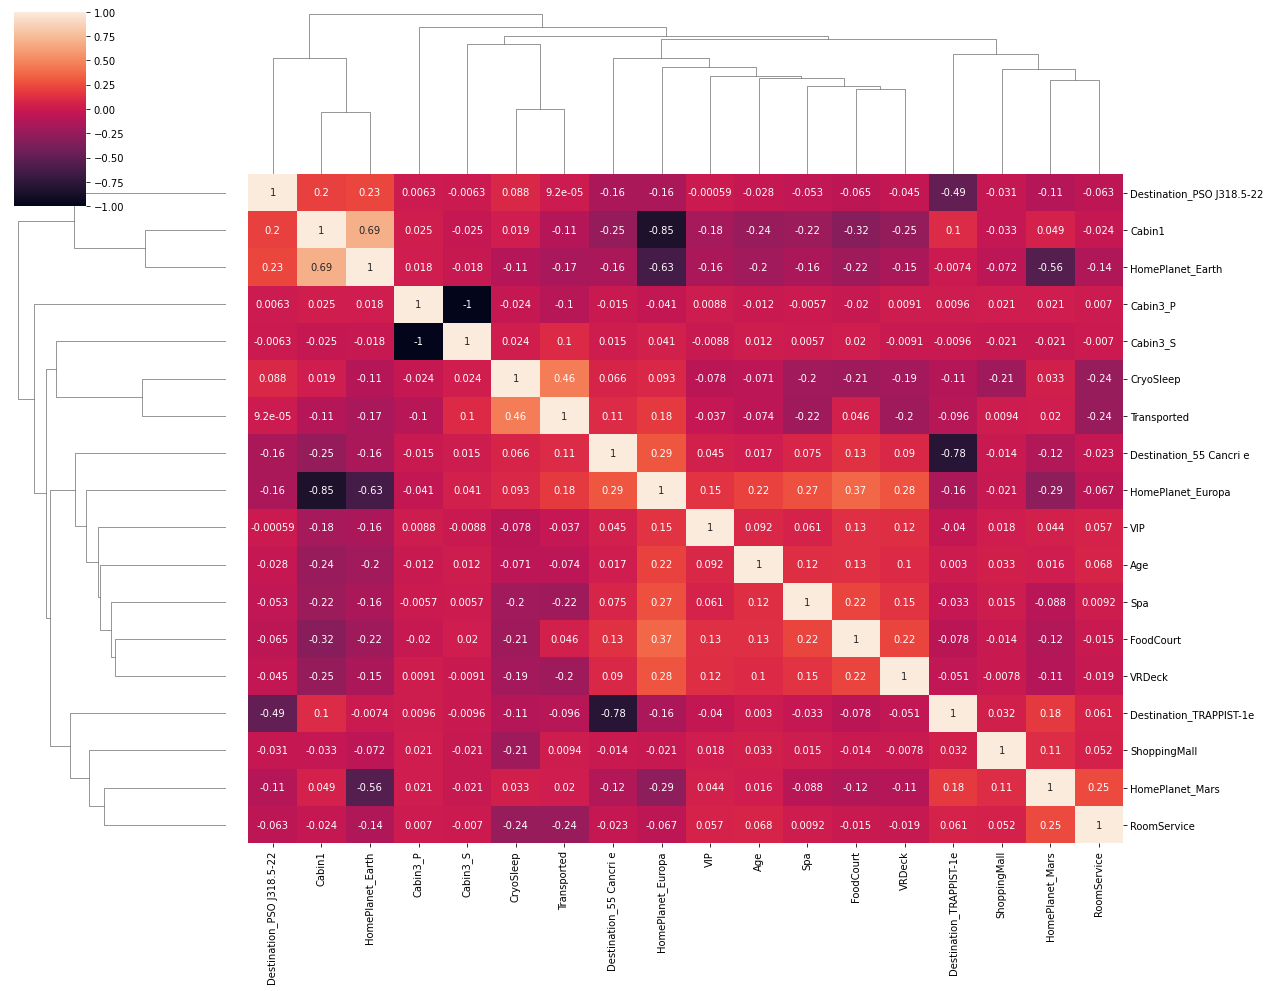

In [31]:
import matplotlib.pyplot as plt

robdf = rob_traindf.corr()
sns.clustermap(robdf, annot = True, vmin = -1, vmax = 1)
plt.gcf().set_size_inches(20, 15)

'''
cabin1 : Homplanet_Europa -0.85
HomePlanet_Earth : HomePlanet_Europa -0.63
HomePlanet_Earth : HomePlanet_Mars -0.56
Cabin3_P : Cabin3_S -1
Destination_55 Cancri e : Destination TARPIST -0.78
Destination TARPIST : Destination PSO -0.49
'''

In [32]:
# [Homeplanet_Europa, Cabin3_P, Destination TARPIST, HomePlanet_Earth] -> 제거

rob_trdf = rob_traindf[rob_traindf.columns.difference(['HomePlanet_Europa', 'HomePlanet_Earth', 'Destination_TRAPPIST-1e', 'Cabin3_P'])]
rob_tsdf = rob_testdf[rob_testdf.columns.difference(['HomePlanet_Europa','HomePlanet_Earth', 'Destination_TRAPPIST-1e', 'Cabin3_P'])]

In [35]:
# x, y 선택

In [33]:
# train x,y
rob_x = rob_trdf[rob_trdf.columns.difference(['Transported'])]
rob_y = rob_trdf['Transported']

# test
rob_test_X = rob_tsdf

In [34]:
r_x_train, r_x_valid, r_y_train, r_y_valid = train_test_split(rob_x, rob_y, test_size = 0.2, random_state = 10)

In [35]:
lgbm_model = LGBMClassifier(learning_rate = 0.01, max_depth =5, n_estimators = 1000)

lgbm_model.fit(r_x_train, r_y_train)

print("Performance on train data:", lgbm_model.score(r_x_train, r_y_train))

Performance on train data: 0.8330457290767903


In [36]:
y_pred_v = lgbm_model.predict(r_x_valid)
print("Performance on validation data:", f1_score(r_y_valid, y_pred_v, average='micro'))

Performance on validation data: 0.8050603795284647


In [37]:
y_pred= lgbm_model.predict(rob_test_X)

In [38]:
y_prediction = []

for i in y_pred:
    if i == 0 :
        y_prediction.append(False)
    elif i == 1:
        y_prediction.append(True)

In [39]:
result = pd.DataFrame({'PassengerId' : PassengerId,
                'Transported': y_prediction})

In [40]:
result.to_csv(r'.\result.csv', index= False)